## 初めに
今回は課題指示書の「ハイパラメータチューニングに慣れる」という目的ベースで課題とは異なる順序で課題をまとめた.


具体的には各要素は守りつつハイパラメータ調整ライブラリoptunaに重点を置いたものとなっている．


このnotebookはCIFAR10を対象にしたCNN構築を一貫して行っている．


In [1]:
# NumPy、Matplotlib、PyTorchをインポートする
import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from optuna.integration.tensorboard import TensorBoardCallback


import optuna
optuna.logging.disable_default_handler()


#set seeds
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


torch_fix_seed()


#入力画像の高さと幅，畳み込み層のカーネルサイズ
in_height = 32
in_width = 32
kernel = 5
BATCHSIZE = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCHSIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCHSIZE, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

2023-07-13 12:02:03.785581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 12:02:04.460080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Files already downloaded and verified
Files already downloaded and verified


In [2]:
class Net(nn.Module):
  def __init__(self, trial, num_layer, mid_units, num_filters):
    super(Net, self).__init__()
    self.activation = get_activation(trial)
    #第1層
    self.convs = nn.ModuleList([nn.Conv2d(in_channels=3, out_channels=num_filters[0], kernel_size=5)])
    self.out_height = in_height - kernel +1
    self.out_width = in_width - kernel +1
    #第2層以降
    for i in range(1, num_layer):
      self.convs.append(nn.Conv2d(in_channels=num_filters[i-1], out_channels=num_filters[i], kernel_size=5))
      self.out_height = self.out_height - kernel + 1
      self.out_width = self.out_width - kernel +1
    #pooling層
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.out_height = int(self.out_height / 2)
    self.out_width = int(self.out_width / 2)
    #線形層
    self.out_feature = self.out_height * self.out_width * num_filters[num_layer - 1]
    self.fc1 = nn.Linear(in_features=self.out_feature, out_features=mid_units)
    self.fc2 = nn.Linear(in_features=mid_units, out_features=10)

  def forward(self, x):
    for i, l in enumerate(self.convs):
      x = l(x)
      x = self.activation(x)
    x = self.pool(x)
    x = x.view(-1, self.out_feature)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [3]:
def train(model, device, train_loader, optimizer):
  model.train()
  loss_corect = 0
  for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()  
        loss_corect+=loss
  return loss_corect / len(train_loader)

def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 1 - correct / len(test_loader.dataset)

In [4]:
def get_optimizer(trial, model):
  optimizer_names = ['Adam', 'MomentumSGD', 'rmsprop']
  optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)

  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

  if optimizer_name == optimizer_names[0]:
    adam_lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-1)
    optimizer = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
  elif optimizer_name == optimizer_names[1]:
    momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
    optimizer = optim.SGD(model.parameters(), lr=momentum_sgd_lr, momentum=0.9, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters())

  return optimizer

In [5]:
def get_activation(trial):
    activation_names = ['ReLU', 'ELU']
    activation_name = trial.suggest_categorical('activation', activation_names)

    if activation_name == activation_names[0]:
        activation = F.relu
    else:
        activation = F.elu

    return activation


In [6]:

def objective(trial):
  # writer = SummaryWriter(log_dir=f"logs/CIFAR10/{datetime.datetime.now()}/learning/trial_{trial.number}/")
  EPOCH = 10
  device = "cuda" if torch.cuda.is_available() else "cpu"

  #畳み込み層の数
  num_layer = trial.suggest_int('num_layer', 3, 7)

  #FC層のユニット数
  mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 300, 10))

  #各畳込み層のフィルタ数
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_layer)]

  model = Net(trial, num_layer, mid_units, num_filters).to(device)
  optimizer = get_optimizer(trial, model)

  for step in range(EPOCH):
    loss=train(model, device, train_loader, optimizer)
    error_rate = test(model, device, test_loader)
    # writer.add_scalar("loss", loss, step)  
    # writer.add_scalar("accuracy", error_rate, step)  
    print(f'{step}fin | error rate {error_rate}')

  print(f'{trial.number} trial fin')
  return error_rate

In [7]:
TRIAL_SIZE = 50
tensorboard_callback = TensorBoardCallback(f"logs/CIFAR10/{datetime.datetime.now()}/Optuna/", metric_name="error_rate")
study = optuna.create_study()
study.optimize(objective, n_trials=TRIAL_SIZE, callbacks=[tensorboard_callback])

print(study.best_params)
print(study.best_value)

best_params_result = study.best_params

/tmp/ipykernel_161/2654388833.py:2: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
  tensorboard_callback = TensorBoardCallback(f"logs/CIFAR10/{datetime.datetime.now()}/Optuna/", metric_name="error_rate")
/tmp/ipykernel_161/3479177853.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 300, 10))
/tmp/ipykernel_161/3479177853.py:13: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_layer)]
/tmp/ipykernel_161/3089434429.py

0fin | error rate 0.5392
1fin | error rate 0.46409999999999996
2fin | error rate 0.3853
3fin | error rate 0.3499
4fin | error rate 0.32089999999999996
5fin | error rate 0.2956
6fin | error rate 0.3046
7fin | error rate 0.28779999999999994
8fin | error rate 0.27490000000000003
9fin | error rate 0.2851
0 trial fin


2023-07-13 12:12:14.096374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 12:12:14.097120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 12:12:14.097235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

0fin | error rate 0.49339999999999995
1fin | error rate 0.38560000000000005
2fin | error rate 0.39280000000000004
3fin | error rate 0.365
4fin | error rate 0.35760000000000003
5fin | error rate 0.3346
6fin | error rate 0.3376
7fin | error rate 0.34299999999999997
8fin | error rate 0.34619999999999995
9fin | error rate 0.3327
1 trial fin


/tmp/ipykernel_161/3089434429.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  adam_lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-1)


0fin | error rate 0.4746
1fin | error rate 0.43720000000000003
2fin | error rate 0.3983
3fin | error rate 0.37629999999999997
4fin | error rate 0.3679
5fin | error rate 0.36639999999999995
6fin | error rate 0.354
7fin | error rate 0.3618
8fin | error rate 0.3853
9fin | error rate 0.376
2 trial fin
0fin | error rate 0.5025
1fin | error rate 0.4131
2fin | error rate 0.37670000000000003
3fin | error rate 0.3417
4fin | error rate 0.33089999999999997
5fin | error rate 0.3226
6fin | error rate 0.30210000000000004
7fin | error rate 0.2893
8fin | error rate 0.28390000000000004
9fin | error rate 0.2741
3 trial fin
0fin | error rate 0.9
1fin | error rate 0.9
2fin | error rate 0.9
3fin | error rate 0.9
4fin | error rate 0.9
5fin | error rate 0.9
6fin | error rate 0.9
7fin | error rate 0.9
8fin | error rate 0.9
9fin | error rate 0.9
4 trial fin
0fin | error rate 0.7549
1fin | error rate 0.6817
2fin | error rate 0.6211
3fin | error rate 0.5941000000000001
4fin | error rate 0.5675
5fin | error rate 

5fin | error rate 0.3477
6fin | error rate 0.3288
7fin | error rate 0.3146
8fin | error rate 0.3087
9fin | error rate 0.3177
30 trial fin
0fin | error rate 0.5646
1fin | error rate 0.471
2fin | error rate 0.4022
3fin | error rate 0.36660000000000004
4fin | error rate 0.36950000000000005
5fin | error rate 0.33530000000000004
6fin | error rate 0.3339
7fin | error rate 0.29179999999999995
8fin | error rate 0.2903
9fin | error rate 0.28359999999999996
31 trial fin
0fin | error rate 0.47330000000000005
1fin | error rate 0.40700000000000003
2fin | error rate 0.37929999999999997
3fin | error rate 0.32730000000000004
4fin | error rate 0.3277
5fin | error rate 0.2934
6fin | error rate 0.3043
7fin | error rate 0.2905
8fin | error rate 0.2996
9fin | error rate 0.31410000000000005
32 trial fin
0fin | error rate 0.5052
1fin | error rate 0.399
2fin | error rate 0.37329999999999997
3fin | error rate 0.33899999999999997
4fin | error rate 0.34840000000000004
5fin | error rate 0.3277
6fin | error rate 0

## まとめ
以上の実行中のハイパラメータは指定範囲の中から選ばれたものを採用しているだけのため, 精度があまり芳しくない.

## 結果
ここから以上で設定したハイパラは以下のものが行った思考の中で最適であると判断された．

## 最適パラメータ結果との比較
精度としてハイパラメータ最適化を行ったネットワークは性能が高く，チューニングを行っていないネットワークに関しては非常に悪い結果となっていることがわかる．


このパラメータ指定を行う際にはこのディレクトリ内に存在する.py を実行することで特定パラメータにおける性能評価を実現できる．

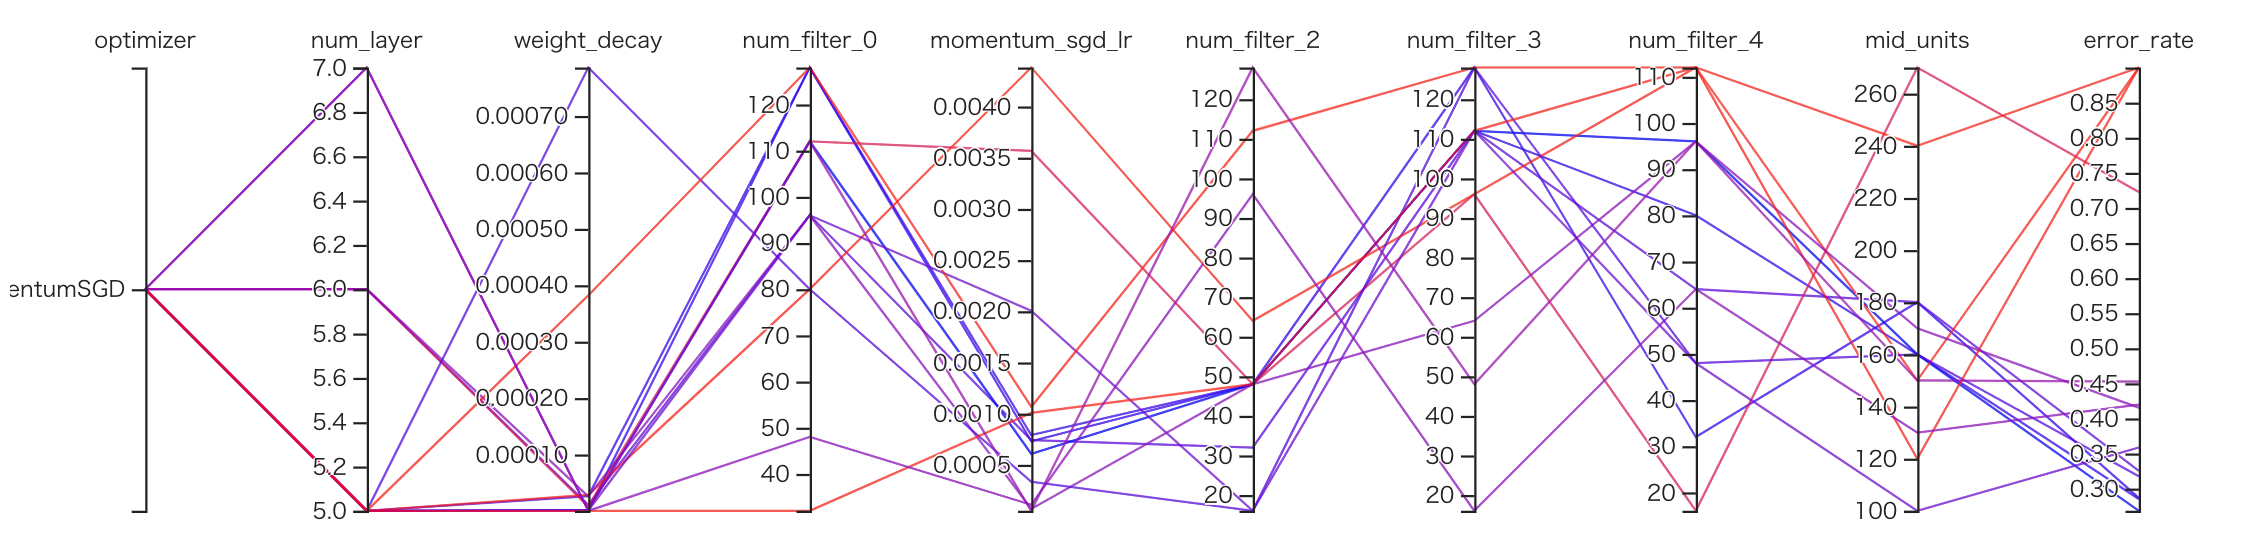

In [1]:
from PIL import Image
img=Image.open("CIFAR10.png")
img

このOptunaを用いたパラメータ探索に関しては ./Optuna_CIFAR10.py で実装を行ったそのため以下のコマンドを実行すると学習およびパラメータ探索が開始される．
上の行為は時間がかかるのでこちらも筆者が実行した結果をtesorboardで確認する．

以下の写真からわかることは各パラーメータ値とそのパラメータ設定で推論を行った時の精度である．

errorrateと他パラメータの関係として以下のことが挙げられる

- 最適化手法(optimizer)は、今回の探索結果において、"MomentumSGD"が多数採用され、エラー率が低くなった． 
- 畳み込み層の数は、5が採用されており、エラー率も低くなった．
- ０層目と３層目の畳み込み層においてフィルター数は、120-130が採用され、エラー率も低減していることから、畳み込みのフィルター数が大きすぎると画像の特徴を大まかにしか抽出できず、小さすぎると画像の局所的な特徴やエラーの影響を大きく受け、エラー率が高くなったと推察される．
- 全結合層のユニット数は、160-180付近が採用されており、160に近づくほどエラー率も低くなった．

以上のことから、今回の最適パラメータ選択において特徴的な点は以下のことが言える．
- 最適化手法: "MomentumSGD"
- 畳み込み層の数: 5
- 畳み込みフィルター数(第０層、第３層): 120-130
- 全結合層のユニット数:160-180

Optunaには最適パラメータを保持する機能があり，その保持パラーメータとそのハイパラで組まれたネットワークのerror rateが出力できる．


この結果より発見されたパラメータは


{'num_layer': 5, 'mid_units': 130.0, 'num_filter_0': 112.0, 'num_filter_1': 32.0, 'num_filter_2': 128.0, 'num_filter_3': 64.0, 'num_filter_4': 128.0, 'activation': 'ELU', 'optimizer': 'Adam', 'weight_decay': 5.779876294485518e-07, 'adam_lr': 3.8129893644089874e-05}


であり，そのネットワークでのerror rateは0.3073


以下の結果より、調整前よりも性能が上がっていることが確認できる．


【最適なパラメータ調整を行なった実行】

0fin | error rate 0.5157

1fin | error rate 0.41290000000000004

2fin | error rate 0.366

3fin | error rate 0.3006

4fin | error rate 0.2793

5fin | error rate 0.25149999999999995

6fin | error rate 0.2589

7fin | error rate 0.2623

8fin | error rate 0.24729999999999996

9fin | error rate 0.2552

【不適切なパラメータ調整を行った実行】

0fin | error rate 0.5445

1fin | error rate 0.4628

2fin | error rate 0.43999999999999995

3fin | error rate 0.40290000000000004

4fin | error rate 0.36529999999999996

5fin | error rate 0.33830000000000005

6fin | error rate 0.3345

7fin | error rate 0.31679999999999997

8fin | error rate 0.3115

9fin | error rate 0.30810000000000004

## all code


In [8]:
# NumPy、Matplotlib、PyTorchをインポートする
import datetime
import numpy as np
import matplotlib.pyplot as plt
import ipdb
import random
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from optuna.integration.tensorboard import TensorBoardCallback


import optuna
optuna.logging.disable_default_handler()


#set seeds
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


torch_fix_seed()


#入力画像の高さと幅，畳み込み層のカーネルサイズ
in_height = 32
in_width = 32
kernel = 5
BATCHSIZE = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCHSIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCHSIZE, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



class Net(nn.Module):
  def __init__(self, trial, num_layer, mid_units, num_filters):
    super(Net, self).__init__()
    self.activation = get_activation(trial)
    #第1層
    self.convs = nn.ModuleList([nn.Conv2d(in_channels=3, out_channels=num_filters[0], kernel_size=5)])
    self.out_height = in_height - kernel +1
    self.out_width = in_width - kernel +1
    #第2層以降
    for i in range(1, num_layer):
      self.convs.append(nn.Conv2d(in_channels=num_filters[i-1], out_channels=num_filters[i], kernel_size=5))
      self.out_height = self.out_height - kernel + 1
      self.out_width = self.out_width - kernel +1
    #pooling層
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.out_height = int(self.out_height / 2)
    self.out_width = int(self.out_width / 2)
    #線形層
    self.out_feature = self.out_height * self.out_width * num_filters[num_layer - 1]
    self.fc1 = nn.Linear(in_features=self.out_feature, out_features=mid_units)
    self.fc2 = nn.Linear(in_features=mid_units, out_features=10)

  def forward(self, x):
    for i, l in enumerate(self.convs):
      x = l(x)
      x = self.activation(x)
    x = self.pool(x)
    x = x.view(-1, self.out_feature)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

def train(model, device, train_loader, optimizer):
  model.train()
  loss_corect = 0
  for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()  
        loss_corect+=loss
  return loss_corect / len(train_loader)

def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 1 - correct / len(test_loader.dataset)

def get_optimizer(trial, model):
  optimizer_names = ['Adam', 'MomentumSGD', 'rmsprop']
  optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)

  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

  if optimizer_name == optimizer_names[0]:
    adam_lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-1)
    optimizer = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
  elif optimizer_name == optimizer_names[1]:
    momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
    optimizer = optim.SGD(model.parameters(), lr=momentum_sgd_lr, momentum=0.9, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters())

  return optimizer

def get_activation(trial):
    activation_names = ['ReLU', 'ELU']
    activation_name = trial.suggest_categorical('activation', activation_names)

    if activation_name == activation_names[0]:
        activation = F.relu
    else:
        activation = F.elu

    return activation

def objective(trial):
  # writer = SummaryWriter(log_dir=f"logs/CIFAR10/{datetime.datetime.now()}/learning/trial_{trial.number}/")
  EPOCH = 10
  device = "cuda" if torch.cuda.is_available() else "cpu"

  #畳み込み層の数
  num_layer = trial.suggest_int('num_layer', 3, 7)

  #FC層のユニット数
  mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 300, 10))

  #各畳込み層のフィルタ数
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_layer)]

  model = Net(trial, num_layer, mid_units, num_filters).to(device)
  optimizer = get_optimizer(trial, model)

  for step in range(EPOCH):
    loss=train(model, device, train_loader, optimizer)
    error_rate = test(model, device, test_loader)
    # writer.add_scalar("loss", loss, step)  
    # writer.add_scalar("accuracy", error_rate, step)  
    print(f'{step}fin | error rate {error_rate}')

  print(f'{trial.number} trial fin')
  return error_rate

TRIAL_SIZE = 10
tensorboard_callback = TensorBoardCallback(f"logs/CIFAR10/{datetime.datetime.now()}/Optuna/", metric_name="error_rate")
study = optuna.create_study()
study.optimize(objective, n_trials=TRIAL_SIZE, callbacks=[tensorboard_callback])

print(study.best_params)
print(study.best_value)

best_params_result = study.best_params

#output
#{'num_layer': 4, 'mid_units': 140.0, 'num_filter_0': 128.0, 'num_filter_1': 112.0, 'num_filter_2': 112.0, 'num_filter_3': 112.0, 'activation': 'ReLU', 'optimizer': 'MomentumSGD', 'weight_decay': 5.2182135446336915e-08, 'momentum_sgd_lr': 0.0004955865902351846}
#0.2519


Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_161/143914539.py:174: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
  tensorboard_callback = TensorBoardCallback(f"logs/CIFAR10/{datetime.datetime.now()}/Optuna/", metric_name="error_rate")
/tmp/ipykernel_161/143914539.py:155: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 300, 10))
/tmp/ipykernel_161/143914539.py:158: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_layer)]
/tmp/ipykernel_161/143914539.py

0fin | error rate 0.9
1fin | error rate 0.9
2fin | error rate 0.9
3fin | error rate 0.9
4fin | error rate 0.9
5fin | error rate 0.9
6fin | error rate 0.9
7fin | error rate 0.9
8fin | error rate 0.9
9fin | error rate 0.9
0 trial fin


/tmp/ipykernel_161/143914539.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)


0fin | error rate 0.9
1fin | error rate 0.9
2fin | error rate 0.9
3fin | error rate 0.9
4fin | error rate 0.9
5fin | error rate 0.9
6fin | error rate 0.9
2fin | error rate 0.40249999999999997
3fin | error rate 0.3638
4fin | error rate 0.33819999999999995
5fin | error rate 0.32120000000000004
6fin | error rate 0.3143
7fin | error rate 0.3013
8fin | error rate 0.29769999999999996
9fin | error rate 0.3073
2 trial fin
0fin | error rate 0.9
1fin | error rate 0.9
2fin | error rate 0.9
3fin | error rate 0.9
4fin | error rate 0.9
5fin | error rate 0.9
6fin | error rate 0.9
7fin | error rate 0.9
8fin | error rate 0.9
9fin | error rate 0.9
3 trial fin
0fin | error rate 0.9
1fin | error rate 0.9
2fin | error rate 0.9
3fin | error rate 0.9
4fin | error rate 0.9
5fin | error rate 0.9
6fin | error rate 0.9
7fin | error rate 0.9
8fin | error rate 0.9
9fin | error rate 0.9
4 trial fin
0fin | error rate 0.9
1fin | error rate 0.9
2fin | error rate 0.9
3fin | error rate 0.9
4fin | error rate 0.9
5fin | e